# Práctica Calificada 2 - Grupo 1
---
<h3>1. OBJETIVO</h3>

**Predicción de tarifas de taxis**<br>
El objetivo de esta evaluación es construir un modelo de aprendizaje que sea capaz de
predecir la tarifa que cobra un taxi de acuerdo a cierta información de entrada.

<h3>2. PAQUETES Y MÓDULOS</h3>

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, average_precision_score, precision_recall_curve
from inspect import signature
from math import sqrt, sin, cos, asin, pi, log
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import os
import matplotlib.pyplot as plt
import ciso8601 #módulo que contiene una implementacion rapida de datetime

%matplotlib inline

<h3>3. MUESTREO</h3>

El conjunto de datos está compuesto por un archivo CSV que contiene alrededor de 55
millones de registros de viajes en taxi. Cada registro contiene la siguiente información:
* **ID**: cadena que identifica de manera única a cada registro
* **pickup_datetime**: timestamp indicando cuando el viaje a empezado
* **pickup_longitude**: número real indicando la ubicación en **longitud** en donde el viaje
empezó
* **pickup_latitude**: número real indicando la ubicación en **latitud** en donde el viaje
empezó
* **dropoff_longitude**: número real indicando la ubicación en longitud en donde el viaje
terminó
* **dropoff_latitude**: número real indicando la ubicación en latitud en donde el viaje
terminó
* **passenger_count**: número entero indicando el número de pasajeros en el servicio de
taxi
* **fare_amount: número real indicando el costo del taxi. Esta es la variable a predecir**

**Población**

In [3]:
%%time
df = pd.read_csv("mitadTrain.csv") # approx 55M 
#df = pd.read_csv("muestra.csv") # approx 55M 
#df = pd.read_csv("100k_train.csv")
#df = pd.read_csv("1M_train.csv")
df.shape

Wall time: 43.8 s


(24999999, 8)

**Muestra**

In [4]:
%%time
#df_s = df.sample(100000, random_state = 7, replace = True)
df_s = df
#df_s.shape

Wall time: 0 ns


In [5]:
df_s.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [6]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24999999 entries, 0 to 24999998
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   key                object 
 1   fare_amount        float64
 2   pickup_datetime    object 
 3   pickup_longitude   float64
 4   pickup_latitude    float64
 5   dropoff_longitude  float64
 6   dropoff_latitude   float64
 7   passenger_count    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 1.5+ GB


<h3>4.LIMPIEZA</h3>

**ELIMINAR NA Y COLUMNA KEY**

In [7]:
df_s.isna().sum() # pandas.DataFrame.isna() vs pandas.DataFrame.isnull(), these two DataFrame methods do exactly the same thing! 

key                    0
fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude    171
dropoff_latitude     171
passenger_count        0
dtype: int64

In [8]:
df_s.dropna(inplace=True)

In [9]:
df_s.isna().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [10]:
df_s.shape

(24999828, 8)

In [11]:
df_s.drop(columns='key', inplace=True)

**DETERMINAR NÚMERO DE PASAJEROS VALIDOS**

Descripción de la columna número de pasajeros (**passenger_count**)

In [12]:
df_s.passenger_count.describe()

count    2.499983e+07
mean     1.685375e+00
std      1.322640e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.080000e+02
Name: passenger_count, dtype: float64

Visualizando **la cantidad de viajes en taxi por el número de pasajeros**

Text(0.5, 1.0, 'Cantidad de viajes en taxi por número de pasajeros')

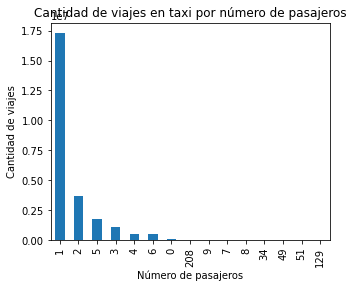

In [13]:
df_s["passenger_count"].value_counts().plot(kind="bar", figsize=(5, 4))
plt.xlabel("Número de pasajeros")
plt.ylabel("Cantidad de viajes")
plt.title("Cantidad de viajes en taxi por número de pasajeros")

Filtramos :  $ ~~1\leq \text{passenger_count}\leq6$

In [14]:
df_s["passenger_count"].between(1,6).value_counts() # Return boolean Series equivalent to left <= series <= right.

True     24911591
False       88237
Name: passenger_count, dtype: int64

**DETERMINAR TARIFA DEL VIAJE VALIDA**

Descripción de la columna monto de la tarifa (**fare_amount**)

In [15]:
df_s.fare_amount.describe()

count    2.499983e+07
mean     1.134218e+01
std      1.574760e+01
min     -3.000000e+02
25%      6.000000e+00
50%      8.500000e+00
75%      1.250000e+01
max      6.155086e+04
Name: fare_amount, dtype: float64

Text(0.5, 1.0, 'Frecuencia de las tarifas de los viajes en intervalos (k,5+k], $k=0,5,10,...}$')

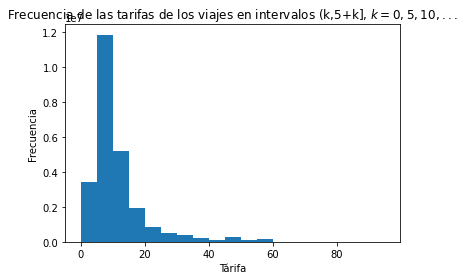

In [16]:
df_s["fare_amount"].plot.hist(alpha=1, stacked=True, bins=list(range(0, 100, 5)))
plt.xlabel("Tárifa")
plt.ylabel("Frecuencia")
plt.title("Frecuencia de las tarifas de los viajes en intervalos (k,5+k], $k=0,5,10,...}$")

Filtramos :  $~~2\leq \text{fare_amount}\leq 200$

In [17]:
df_s[(df_s['fare_amount'] < 0)].shape # negativos

(1059, 7)

In [18]:
df_s[(df_s['fare_amount'] > 0) & (df_s['fare_amount'] < 2)].shape # mayor a cero y menor a dos

(366, 7)

In [19]:
df_s[(df_s['fare_amount'] > 200)].shape # mayores a 200

(779, 7)

In [20]:
df_s["fare_amount"].between(2,200).value_counts()

True     24996973
False        2855
Name: fare_amount, dtype: int64

**DETERMINAR REGIÓN VALIDA**

In [21]:
#fig = px.scatter_mapbox(df_s, lat="pickup_latitude", lon="pickup_longitude",
   #                    color_discrete_sequence=["green"], zoom=5, height=300)
#fig = px.scatter_mapbox(df_s[:1000], lat="pickup_latitude", lon="pickup_longitude",
#                        color='fare_amount', zoom=5, height=300)
#fig.update_layout(mapbox_style="open-street-map")
#fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
#fig.show()

**LIMPIEZA  GENERAL**

In [22]:
%%time
def filter_data(dataframe):
    #Solo quedan si cumplen las condiciones 
    return dataframe[
        #Coordenadas Ilegales
        (-180.0 <= dataframe["pickup_longitude"])&
        (dataframe["pickup_longitude"] <= 180.0)&
        (-90.0 <= dataframe["pickup_latitude"])&
        (dataframe["pickup_latitude"] <= 90.0)&
        (-180.0 <= dataframe["dropoff_longitude"])&
        (dataframe["dropoff_longitude"] <= 180.0)&
        (-90.0 <= dataframe["dropoff_latitude"])&
        (dataframe["dropoff_latitude"] <= 90.0)& 
        #(df_s["pickup_longitude"] != df_s["dropoff_longitude"])&
        #Fare amount  
        (2.0 <= dataframe["fare_amount"])&
        (dataframe["fare_amount"] <= 100)&
        # passenger_count
        (1<=dataframe["passenger_count"])&
        (dataframe["passenger_count"]<= 6)]    
     
print ("Shape antes del limpieza general: ", df_s.shape)
data = filter_data(df_s)
print ("Shape despues del limpieza general: ", data.shape)
print ("Limpiando %d registros"%(df_s.shape[0] - data.shape[0]))

Shape antes del limpieza general:  (24999828, 7)
Shape despues del limpieza general:  (24898776, 7)
Limpiando 101052 registros
Wall time: 1.78 s


**INTERCAMBIAR COORDENADAS DE PUNTOS PARA CONSIDERARLOS DENTRO DE LA REGIÓN VALIDA**

In [23]:
def swap_coordinates (dataframe,
    city_limits = { 
        "lon_min":-76,
        "lon_max":-73,
        "lat_min":38,
        "lat_max":50} ):
    #Intercambia las coordenadas de los viajes en 
    # la region [38 , 50]x[-76, -73]
    # la region de principarl de trabajo
    # (cuidad de NY) es : [-76, -73]x[38 , 50]
    datap = dataframe
    city_interchange = (
        (datap["pickup_longitude"] > city_limits["lat_min"])&
        (datap["pickup_longitude"] < city_limits["lat_max"])&
        (datap["pickup_latitude"] > city_limits["lon_min"] )& #-74.252444 
        (datap["pickup_latitude"] < city_limits["lon_max"] )& 

        (datap["dropoff_longitude"] > city_limits["lat_min"])&
        (datap["dropoff_longitude"] < city_limits["lat_max"])&
        (datap["dropoff_latitude"] >  city_limits["lon_min"] )&
        (datap["dropoff_latitude"] <  city_limits["lon_max"] ) 
        )
    print ( "Numero de reflejos : ",city_interchange.sum())
    
    datap.loc[city_interchange] = datap.loc[city_interchange].rename(columns={
        'pickup_longitude':'pickup_latitude',
        'pickup_latitude':'pickup_longitude',
        'dropoff_latitude':'dropoff_longitude',
        'dropoff_longitude':'dropoff_latitude'})
    return datap

data = swap_coordinates(data)


Numero de reflejos :  12106


c:\users\jesús\documents\pc2\torchdemo\venv\lib\site-packages\pandas\core\indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


**DETERMINAR LA REGIÓN VALIDA**

In [24]:
#long_border = (-74.03, -73.75)
#lat_border = (40.63, 40.85)
def filter_out_of_city(dataframe,city_limits = { 
        "lon_min":-74.03 ,
        "lon_max":-73.75,
        "lat_min":40.63,
        "lat_max":40.85}):
    #Solo quedan si estan dentro de la ciudad 
    return dataframe[
        (city_limits["lon_min"]<= dataframe["pickup_longitude"])&
        (dataframe["pickup_longitude"] <= city_limits["lon_max"])&
        (city_limits["lat_min"]<= dataframe["pickup_latitude"])&
        (dataframe["pickup_latitude"] <= city_limits["lat_max"])&
        (city_limits["lon_min"] <= dataframe["dropoff_longitude"])&
        (dataframe["dropoff_longitude"] <= city_limits["lon_max"])&
        (city_limits["lat_min"]<= dataframe["dropoff_latitude"])&
        (dataframe["dropoff_latitude"] <= city_limits["lat_max"])]

print ("Shape antes de la limpieza por región: ", data.shape)
data = filter_out_of_city(data)
print ("Shape despues de la limpieza por región: ", data.shape)
print ("Limpiando %d registros acumulados en total hasta ahora "%(df_s.shape[0] - data.shape[0]))

Shape antes de la limpieza por región:  (24898776, 7)
Shape despues de la limpieza por región:  (24079365, 7)
Limpiando 920463 registros acumulados en total hasta ahora 


In [25]:
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [26]:
#fig = px.scatter_mapbox(data.nlargest(1000,"fare_amount"), lat="pickup_latitude", lon="pickup_longitude",
#                        color='fare_amount', zoom=5, height=300)
#fig.update_layout(mapbox_style="open-street-map")
#fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
#fig.show()

**EXPLORACIÓN DE TARIFAS POR AEROPUERTO**

<h2>5. INGENIERÍA DE CARACTERÍSTICAS</h2>

In [27]:
def isInside( column_lat ,column_lon ,region):
    return (column_lat>=region['min_lat'])&(column_lat<=region['max_lat'])&(column_lon>=region['min_long'])&(column_lon<=region['max_long'])    

**CONTROL DE VIAJES PARTIENDO O LLEGANDO A LOS AEROPUERTOS DE NEW YORK**

In [28]:
JFK={'min_long':-73.8352,'min_lat':40.6195,'max_long':-73.7401, 'max_lat':40.6659}
EWR={'min_long':-74.1925,'min_lat':40.6700, 'max_long':-74.1531, 'max_lat':40.7081}
LG={'min_long':-73.8895, 'min_lat':40.7664,'max_long':-73.8550,'max_lat':40.7931}


In [29]:
%%time
data['pickup_airport'] = isInside(data.pickup_latitude, data.pickup_longitude , JFK)|isInside(data.pickup_latitude, data.pickup_longitude ,EWR) | isInside(data.pickup_latitude, data.pickup_longitude ,LG)
data['dropoff_airport'] = isInside(data.dropoff_latitude, data.dropoff_longitude , JFK) |isInside(data.dropoff_latitude, data.dropoff_longitude ,EWR) |isInside(data.dropoff_latitude, data.dropoff_longitude ,LG)


Wall time: 758 ms


In [30]:
data['pickup_airport'] = data['pickup_airport'].astype(int)
data['dropoff_airport'] = data['dropoff_airport'].astype(int)

<h5>SEPARAR DATETIME EN YEAR, MONTH, DAY, HOUR Y WEEKDAY</h5>

In [31]:
%%time
def f2(datestr):
    return ciso8601.parse_datetime(datestr [ :-4])

def separate_datetime_to_features(dataframe): 
    dataframe ['pickup_datetime'] =dataframe.pickup_datetime.apply(f2)  #pd.to_datetime(data.pickup_datetime ,infer_datetime_format=True) # convertimos a tipo de dato de datetime
    dataframe['year'] = dataframe['pickup_datetime'].dt.year
    dataframe['month'] = dataframe['pickup_datetime'].dt.month
    dataframe['day'] = dataframe['pickup_datetime'].dt.day
    dataframe['hour'] = dataframe['pickup_datetime'].dt.hour
    dataframe['weekday'] = dataframe['pickup_datetime'].dt.weekday
    dataframe.drop(columns='pickup_datetime', inplace=True)
    return dataframe

data = separate_datetime_to_features(data)

Wall time: 21.8 s


In [32]:
data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_airport,dropoff_airport,year,month,day,hour,weekday
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,0,0,2009,6,15,17,0
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,0,0,2010,1,5,16,1
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0,0,2011,8,18,0,3
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,0,0,2012,4,21,4,5
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,0,0,2010,3,9,7,1


In [32]:
#data.drop(columns='Unnamed: 0', inplace=True)

<h5>DETERMINAR LA DISTANCIA DE HAVERSINE ENTRE PUNTOS DADO SU LATITUD Y LONGITUD</h5>

In [33]:
def haversine(lon1, lat1, lon2, lat2):
    # Haversine vectorizado usando funciones de np
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    km = 6367 * 2 * np.arcsin(np.sqrt(a))
    km[km < 0.00008] = 0.00008
    return km
    #print(Haversine(39.50, 98.35, 48.8567, 2.3508))


In [34]:
%time
data['distance'] = haversine(data['pickup_longitude'],data['pickup_latitude'] , data['dropoff_longitude'], data['dropoff_latitude'])
data.describe()

Wall time: 0 ns


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_airport,dropoff_airport,year,month,day,hour,weekday,distance
count,2.407936e+07,2.407936e+07,2.407936e+07,2.407936e+07,2.407936e+07,2.407936e+07,2.407936e+07,2.407936e+07,2.407936e+07,2.407936e+07,2.407936e+07,2.407936e+07,2.407936e+07,2.407936e+07
mean,1.099188e+01,-7.397568e+01,4.075094e+01,-7.397467e+01,4.075118e+01,1.691428e+00,3.423458e-02,2.091671e-02,2.011740e+03,6.267964e+00,1.571321e+01,1.352150e+01,3.039959e+00,3.199965e+00
std,8.722270e+00,3.351776e-02,2.625631e-02,3.174854e-02,2.846848e-02,1.307455e+00,1.818312e-01,1.431055e-01,1.865077e+00,3.436217e+00,8.684156e+00,6.499104e+00,1.948385e+00,3.357810e+00
min,2.000000e+00,-7.403000e+01,4.063000e+01,-7.403000e+01,4.063000e+01,1.000000e+00,0.000000e+00,0.000000e+00,2.009000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,8.000000e-05
25%,6.000000e+00,-7.399227e+01,4.073666e+01,-7.399154e+01,4.073592e+01,1.000000e+00,0.000000e+00,0.000000e+00,2.010000e+03,3.000000e+00,8.000000e+00,9.000000e+00,1.000000e+00,1.248482e+00
50%,8.500000e+00,-7.398211e+01,4.075336e+01,-7.398068e+01,4.075385e+01,1.000000e+00,0.000000e+00,0.000000e+00,2.012000e+03,6.000000e+00,1.600000e+01,1.400000e+01,3.000000e+00,2.132952e+00
75%,1.250000e+01,-7.396845e+01,4.076746e+01,-7.396585e+01,4.076823e+01,2.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,9.000000e+00,2.300000e+01,1.900000e+01,5.000000e+00,3.825784e+00
max,1.000000e+02,-7.375000e+01,4.085000e+01,-7.375000e+01,4.085000e+01,6.000000e+00,1.000000e+00,1.000000e+00,2.015000e+03,1.200000e+01,3.100000e+01,2.300000e+01,6.000000e+00,2.809578e+01


<h4> SELECCIÓN DE VARIABLES</h4>

In [35]:
data.columns.to_list()

['fare_amount',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count',
 'pickup_airport',
 'dropoff_airport',
 'year',
 'month',
 'day',
 'hour',
 'weekday',
 'distance']

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24079365 entries, 0 to 24999998
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   fare_amount        float64
 1   pickup_longitude   float64
 2   pickup_latitude    float64
 3   dropoff_longitude  float64
 4   dropoff_latitude   float64
 5   passenger_count    int64  
 6   pickup_airport     int32  
 7   dropoff_airport    int32  
 8   year               int64  
 9   month              int64  
 10  day                int64  
 11  hour               int64  
 12  weekday            int64  
 13  distance           float64
dtypes: float64(6), int32(2), int64(6)
memory usage: 2.5 GB


In [37]:
#data.drop(columns=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], inplace=True)

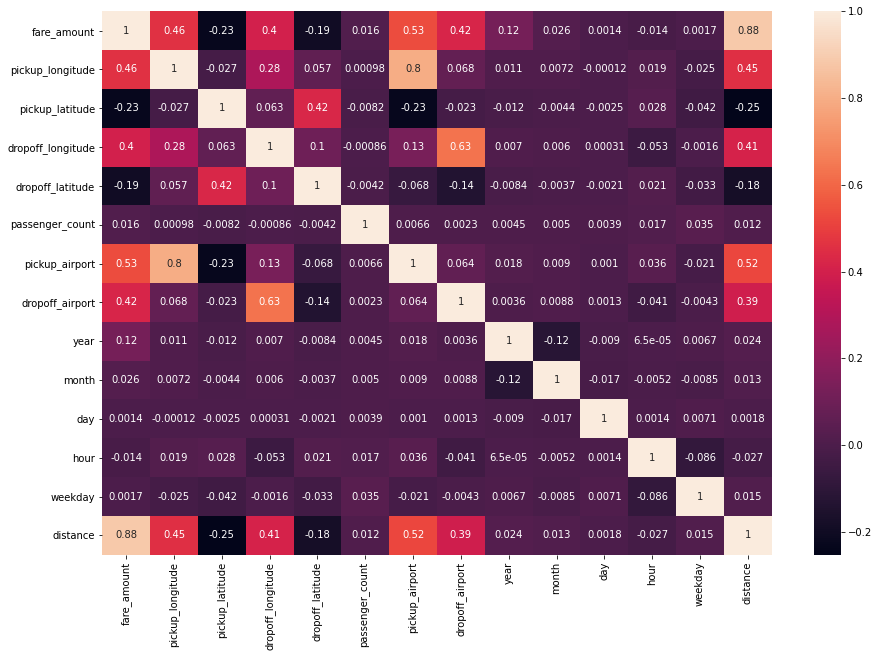

Wall time: 13.3 s


In [38]:
%%time
fig, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(data.corr(), annot=True, ax=ax)
plt.show()

In [39]:
#predictors = ['distance', 'pickup_JFK','dropoff_JFK','pickup_EWR','dropoff_EWR','pickup_LG','dropoff_LG']
#predictors = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','distance', 'pickup_airport', 'dropoff_airport', 'year','month','hour']

predictors = ['distance', 'pickup_airport', 'dropoff_airport', 'year','month','hour']
salida = 'fare_amount'
X = data[predictors]
y = data[salida]
#ESCALANDO
scaler = StandardScaler()
X = scaler.fit_transform(X)

#pol_features = PolynomialFeatures(degree=4)
#X = pol_features.fit_transform(X)

**TARIFA PROMEDIO POR HORA**<br>
Se observa una mayor tarifa a las 4am y 5am.

In [ ]:
data.groupby(["hour"]).fare_amount.mean().plot.bar(x='hour',y='fare_amount')
plt.show()

**TARIFA PROMEDIO POR AÑO**<br>
Se observa un crecimiento de la tarifa en promedio cada año

In [ ]:
data.groupby(["year"]).fare_amount.mean().plot.bar(x='hour',y='fare_amount')
plt.show()

## 6. Entrenamiento del modelo

In [40]:
def print_metrics(y_test, y_pred):
    r2score = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))

    print("MSE", mse)
    print("RMSE",rmse)
    print("R2", r2score)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, test_size=0.3)

# Red neuronal de capas densas


In [45]:
import torch
from torch import nn, optim
import torch.nn.functional as F



In [46]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=7)

In [47]:
print(type(X_train))
print(type(X_val))
print(type(y_val))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [48]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_val = torch.from_numpy(X_val).float()
y_val = torch.squeeze(torch.from_numpy(y_val.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

torch.Size([11798888, 6]) torch.Size([11798888])
torch.Size([5056667, 6]) torch.Size([5056667])


In [49]:
class Net(nn.Module):
    def __init__(self, n_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features,8)
        self.fc2 = nn.Linear(8, 4)
        #self.fc3 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, 1)    
        self.dropout = nn.Dropout(0.125)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = self.dropout(x)
        x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        #x = F.relu(self.fc3(x))
        return self.fc3(x)

In [50]:
net = Net(X_train.shape[1])

In [58]:
optimizer = optim.Adam(net.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [52]:
print("cuda available :" , torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cuda available : True


In [53]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_val = X_val.to(device)
y_val = y_val.to(device)

In [55]:
net = net.to(device)
criterion = criterion.to(device)

In [70]:
#Se guardo de un entrenamiento previo 
net = torch.load("best_model12.pth")
net = net.to(device)

In [71]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)

In [72]:
min_test_loss = float("inf")
for epoch in range(4001):
#while True:
    epoch = epoch+1 
    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    if epoch % 100 == 0:
        y_test_pred = net(X_val)
        y_test_pred = torch.squeeze(y_test_pred)
        test_loss = criterion(y_test_pred, y_val)
        print(f'''Epoca {epoch} Conjunto de entrenamiento - perdida: {round_tensor(train_loss)} \n Conjunto de prueba - perdida: {round_tensor(test_loss)}''')
        if round_tensor(test_loss) < min_test_loss:
            min_test_loss = round_tensor(test_loss)
            torch.save(net, "best_model.pth")
            print("------------ Guardado best model ------------ Loss:",min_test_loss)
            
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

Epoca 100 Conjunto de entrenamiento - perdida: 12.653 
 Conjunto de prueba - perdida: 12.659
------------ Guardado best model ------------ Loss: 12.659
Epoca 200 Conjunto de entrenamiento - perdida: 12.653 
 Conjunto de prueba - perdida: 12.659
Epoca 300 Conjunto de entrenamiento - perdida: 12.653 
 Conjunto de prueba - perdida: 12.659


KeyboardInterrupt: 

best_model12 se obtuvo de un entrenamiento previo con cerca de 70 000 epocas pero en un conjunto de datos mas pequeño
al cargarlo e intentar continuar con el entrenamiento el loss queda estancando en 12.653 esto se puede deber a que nos encomtramos en un minimo local y no tenemos momentum por que inciamos el entremamiento nuevamente. 

In [74]:
net = torch.load("best_model.pth")
X_test = torch.from_numpy(X_test).float()
net = net.to("cpu")
y_pred = net(X_test)
y_pred = y_pred.detach().numpy()


In [75]:
print_metrics(y_test, y_pred)


MSE 12.655530050933105
RMSE 3.557461180523704
R2 0.8335303560359626
